# Classificação de Lesões Cervicais a partir de CSV

## 1. Configuração do Ambiente e Carregamento de Dados

In [1]:
import os
import shutil
from pathlib import Path
import random   
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Caminhos para os arquivos de dados (usando barras normais para compatibilidade)
train_csv_path = 'c:/Users/IA/Desktop/citology pipeline Train/train_data.csv'
val_csv_path = 'c:/Users/IA/Desktop/citology pipeline Train/val_data.csv'
test_csv_path = 'c:/Users/IA/Desktop/citology pipeline Train/test_data.csv'

# Carregar os dataframes
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Dados de Treino:")
print(train_df.head())
print("\nDados de Validação:")
print(val_df.head())
print("\nDados de Teste:")
print(test_df.head())

Dados de Treino:
  lesion_type                          image_path
0       LISIL  Dataset/Tile/LISIL/NL_28_ (12).jpg
1       LISIL    Dataset/Tile/LISIL/parab_072.bmp
2       LISIL          Dataset/Tile/LISIL/050.bmp
3       LISIL   Dataset/Tile/LISIL/NL_37_ (9).jpg
4       LISIL      Dataset/Tile/LISIL/koi_203.bmp

Dados de Validação:
  lesion_type                        image_path
0       LISIL        Dataset/Tile/LISIL/047.bmp
1       HISIL  Dataset/Tile/HISIL/scc_1 (1).jpg
2       LISIL        Dataset/Tile/LISIL/203.bmp
3       LISIL        Dataset/Tile/LISIL/192.bmp
4       LISIL  Dataset/Tile/LISIL/parab_025.bmp

Dados de Teste:
  lesion_type                         image_path
0       LISIL     Dataset/Tile/LISIL/sup_121.bmp
1       HISIL  Dataset/Tile/HISIL/HSIL_2 (4).jpg
2       LISIL     Dataset/Tile/LISIL/koi_016.bmp
3       LISIL  Dataset/Tile/LISIL/NL_15_ (2).jpg
4       LISIL  Dataset/Tile/LISIL/NL_2_ (14).jpg


## 2. Preparação dos Geradores de Imagens

In [ ]:
from random import shuffle


# Configurações
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Parâmetros do modelo

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS_FASE1 = 10
EPOCHS_FASE2 = 100
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# Diretório base onde as imagens estão localizadas
image_dir = 'c:/Users/IA/Desktop/citology pipeline Train/'
BASE_DIR = Path("C:/Users/IA/Desktop/citology pipeline Train")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_path',
    y_col='lesion_type',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_path',
    y_col='lesion_type',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='image_path',
    y_col='lesion_type',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1159 validated image filenames belonging to 2 classes.
Found 249 validated image filenames belonging to 2 classes.
Found 249 validated image filenames belonging to 2 classes.


c:\Users\IA\miniconda3\envs\train-env\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


## 3. Construção do Modelo (MobileNet)

In [4]:
# base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# base_model.trainable = False

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)

# num_classes = len(train_generator.class_indices)
# predictions = Dense(num_classes, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [5]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dropout

def create_mobilenet_model(input_shape=IMG_SIZE + (3,), num_classes=2):
    """Criar modelo MobileNetV2 com transfer learning"""
    
    # Carregar MobileNetV2 pré-treinado (sem o topo)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Congelar as camadas da base
    base_model.trainable = False
    
    # Adicionar camadas customizadas
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model


In [6]:

# Criar modelo
model, base_model = create_mobilenet_model()

# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("Modelo criado e compilado!")
print(f"Número total de camadas: {len(model.layers)}")
print(f"Camadas congeladas: {sum(1 for layer in base_model.layers if not layer.trainable)}")
print(f"Camadas treináveis: {sum(1 for layer in model.layers if layer.trainable)}")

Modelo criado e compilado!
Número total de camadas: 6
Camadas congeladas: 154
Camadas treináveis: 5


In [7]:
# Mostrar resumo do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2

## 4. Treinamento do Modelo

In [8]:
# EPOCHS = 20

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // BATCH_SIZE,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // BATCH_SIZE,
#     epochs=EPOCHS
# )

In [9]:
# Callbacks para o treinamento
checkpoint_path = BASE_DIR / "best_model_fase1.h5"

callbacks_fase1 = [
    ModelCheckpoint(
        str(checkpoint_path),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("Iniciando Fase 1: Treinamento do topo customizado...")

history_fase1 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS_FASE1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_fase1,
    verbose=1
)

print("Fase 1 concluída!")

Iniciando Fase 1: Treinamento do topo customizado...
Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.7877 - precision: 0.7877 - recall: 0.7877
Epoch 1: val_loss improved from inf to 0.31482, saving model to C:\Users\IA\Desktop\citology pipeline Train\best_model_fase1.h5
37/37 [==============================] - 57s 1s/step - loss: 0.6533 - accuracy: 0.7877 - precision: 0.7877 - recall: 0.7877 - val_loss: 0.3148 - val_accuracy: 0.8675 - val_precision: 0.8675 - val_recall: 0.8675
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8378 - precision: 0.8378 - recall: 0.8378
Epoch 2: val_loss improved from 0.31482 to 0.28026, saving model to C:\Users\IA\Desktop\citology pipeline Train\best_model_fase1.h5
37/37 [==============================] - 53s 1s/step - loss: 0.4167 - accuracy: 0.8378 - precision: 0.8378 - recall: 0.8378 - val_loss: 0.2803 - val_accuracy: 0.8996 - val_precision: 0.8996 - val_recall: 0.8996
Epo

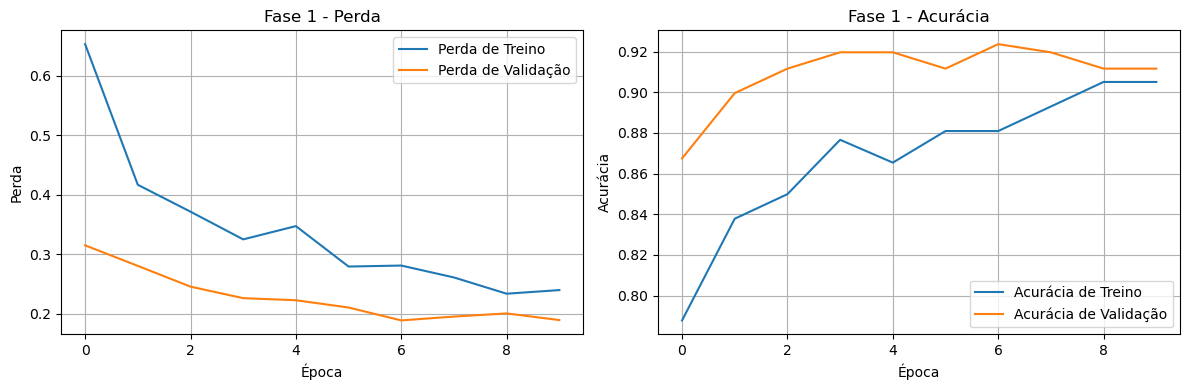

In [10]:
def plot_training_history(history, title="Histórico de Treinamento"):
    """Plotar histórico de treinamento"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plotar perda
    ax1.plot(history.history['loss'], label='Perda de Treino')
    ax1.plot(history.history['val_loss'], label='Perda de Validação')
    ax1.set_title(f'{title} - Perda')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)
    
    # Plotar acurácia
    ax2.plot(history.history['accuracy'], label='Acurácia de Treino')
    ax2.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    ax2.set_title(f'{title} - Acurácia')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Acurácia')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_fase1, "Fase 1")

## 8. Fase 2: Fine-tuning do Modelo

In [11]:
# Descongelar as últimas camadas da base para fine-tuning
base_model.trainable = True

# Congelar as primeiras camadas (manter early layers congeladas)
fine_tune_at = 100  # Descongelar a partir da camada 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar com taxa de aprendizado menor
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print(f"Fine-tuning: {len([l for l in base_model.layers if l.trainable])} camadas treináveis")
print(f"Camadas congeladas: {len([l for l in base_model.layers if not l.trainable])}")

Fine-tuning: 54 camadas treináveis
Camadas congeladas: 100


In [12]:
# Callbacks para fine-tuning
checkpoint_path_fase2 = BASE_DIR / "best_model_fase2.h5"

callbacks_fase2 = [
    ModelCheckpoint(
        str(checkpoint_path_fase2),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Iniciando Fase 2: Fine-tuning...")

history_fase2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS_FASE2,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_fase2,
    initial_epoch=EPOCHS_FASE1,
    verbose=1
)

print("Fase 2 concluída!")


# 1. Definir o caminho da pasta 'models'
# (Assumindo que BASE_DIR é um objeto Path)
models_dir = BASE_DIR / "models"

# 2. Criar a pasta 'models' se ela não existir
models_dir.mkdir(parents=True, exist_ok=True)

# 3. Definir o nome do arquivo do modelo final (use .keras)
final_model_path = models_dir / "final_mobilenet_model.keras"

# 4. Salvar o modelo final
print(f"Salvando modelo final em: {final_model_path}")
model.save(final_model_path)

print("Modelo salvo com sucesso!")

Iniciando Fase 2: Fine-tuning...
Epoch 11/20
37/37 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8758 - precision_1: 0.8758 - recall_1: 0.8758
Epoch 11: val_loss improved from inf to 0.20325, saving model to C:\Users\IA\Desktop\citology pipeline Train\best_model_fase2.h5
37/37 [==============================] - 58s 1s/step - loss: 0.3615 - accuracy: 0.8758 - precision_1: 0.8758 - recall_1: 0.8758 - val_loss: 0.2032 - val_accuracy: 0.9438 - val_precision_1: 0.9438 - val_recall_1: 0.9438 - lr: 1.0000e-05
Epoch 12/20
37/37 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8818 - precision_1: 0.8818 - recall_1: 0.8818
Epoch 12: val_loss improved from 0.20325 to 0.19840, saving model to C:\Users\IA\Desktop\citology pipeline Train\best_model_fase2.h5
37/37 [==============================] - 55s 1s/step - loss: 0.3070 - accuracy: 0.8818 - precision_1: 0.8818 - recall_1: 0.8818 - val_loss: 0.1984 - val_accuracy: 0.9478 - val_precision_1: 0.9478 -

In [ ]:
import re # Importe a biblioteca de Expressões Regulares (Regex)

# Combinar históricos
def combine_histories(history1, history2):
    """
    Combinar históricos de duas fases de treinamento, lidando com
    a renomeação automática de métricas do Keras (ex: precision_1 -> precision_2).
    """
    
    h1 = history1.history
    h2 = history2.history
    
    # 1. Criar um mapa de 'chave_base' -> 'chave_real' para a history2
    # Ex: {'precision': 'precision_2', 'val_precision': 'val_precision_2', 'loss': 'loss'}
    h2_base_map = {}
    for key2 in h2.keys():
        # Remove o sufixo numérico (ex: _1, _2) para obter a chave base
        # 'val_precision_2' -> 'val_precision'
        # 'loss' -> 'loss'
        base_key = re.sub(r'_\d+$', '', key2)
        h2_base_map[base_key] = key2

    combined = {}
    
    # 2. Iterar pela history1 e combinar com a chave correspondente da history2
    for key1 in h1.keys():
        # Obter a chave base para a key1 (ex: 'precision_1' -> 'precision')
        base_key1 = re.sub(r'_\d+$', '', key1)
        
        # Verificar se a chave base existe no mapa da h2
        if base_key1 in h2_base_map:
            # Encontrar a chave real da h2 (ex: 'precision_2')
            key2_mapped = h2_base_map[base_key1]
            
            # Combinar as listas
            combined[key1] = h1[key1] + h2[key2_mapped]
        else:
            print(f"Aviso: Chave '{key1}' da Fase 1 não encontrou "
                  f"correspondente ('{base_key1}') na Fase 2. Pulando.")
            
    return combined


# Chamar a função adaptada
combined_history = combine_histories(history_fase1, history_fase2)

# Criar objeto mock para plotagem
class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

full_history = MockHistory(combined_history)

# Plotar o resultado combinado
plot_training_history(full_history, "Treinamento Completo (Fase 1 + Fase 2)")

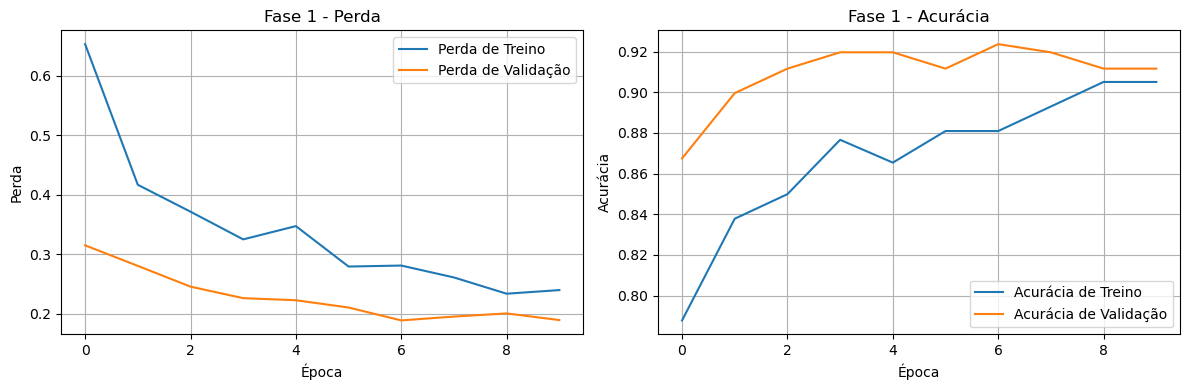

In [14]:
plot_training_history(history_fase1, "Fase 1")

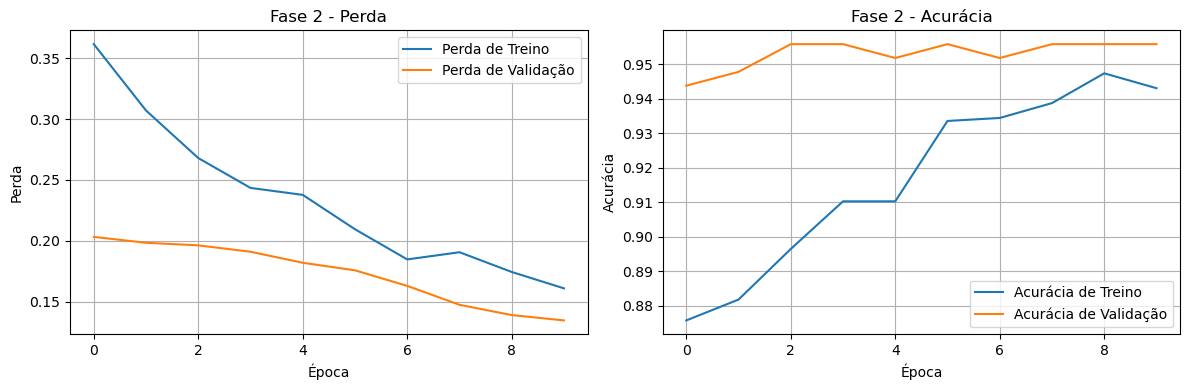

In [15]:
plot_training_history(history_fase2, "Fase 2")


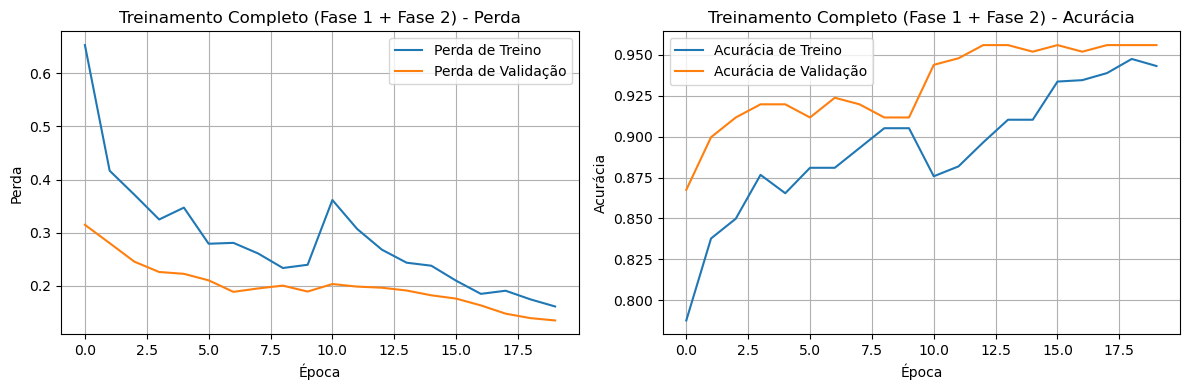

In [16]:

# Plotar o resultado combinado
plot_training_history(full_history, "Treinamento Completo (Fase 1 + Fase 2)")

## 5. Avaliação do Modelo

In [17]:
# Avaliar modelo no conjunto de validação
print("Avaliando modelo no conjunto de validação...")

val_loss, val_accuracy, val_precision, val_recall = model.evaluate(
    validation_generator,
    steps=len(validation_generator),
    verbose=1
)

print(f"\nResultados da Validação:")
print(f"Perda: {val_loss:.4f}")
print(f"Acurácia: {val_accuracy:.4f}")
print(f"Precisão: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

Avaliando modelo no conjunto de validação...
8/8 [==============================] - 9s 1s/step - loss: 0.1346 - accuracy: 0.9558 - precision_1: 0.9558 - recall_1: 0.9558

Resultados da Validação:
Perda: 0.1346
Acurácia: 0.9558
Precisão: 0.9558
Recall: 0.9558


In [20]:
# Avaliar modelo no conjunto de teste
print("Avaliando modelo no conjunto de teste...")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

print(f"\nResultados do Teste:")
print(f"Perda: {test_loss:.4f}")
print(f"Acurácia: {test_accuracy:.4f}")
print(f"Precisão: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

Avaliando modelo no conjunto de teste...
249/249 [==============================] - 17s 69ms/step - loss: 0.1600 - accuracy: 0.9317 - precision_1: 0.9317 - recall_1: 0.9317

Resultados do Teste:
Perda: 0.1600
Acurácia: 0.9317
Precisão: 0.9317
Recall: 0.9317


In [28]:
# test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples)
# print(f'Acurácia no conjunto de teste: {test_acc:.4f}')

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Acurácia de Treino')
# plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
# plt.legend(loc='lower right')
# plt.title('Acurácia de Treino e Validação')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Perda de Treino')
# plt.plot(epochs_range, val_loss, label='Perda de Validação')
# plt.legend(loc='upper right')
# plt.title('Perda de Treino e Validação')
# plt.show()

In [ ]:
# Y_pred = model.predict(test_generator, steps=test_generator.samples)
# y_pred = np.argmax(Y_pred, axis=1)

# true_classes = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())

# print('Matriz de Confusão')
# cm = confusion_matrix(true_classes, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Previsto')
# plt.ylabel('Verdadeiro')
# plt.title('Matriz de Confusão')
# plt.show()

# print('\nRelatório de Classificação')
# print(classification_report(true_classes, y_pred, target_names=class_labels))